In [1]:
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import theano.tensor as T
import theano
import lasagne
from lasagne.utils import as_tuple

import cv2
import h5py as h5

Using gpu device 0: GeForce GTX TITAN Z (CNMeM is disabled, cuDNN 4007)


In [31]:
import model
reload(model)
import test
reload(test)
from test import *
input_shp = (224, 224)

(input_shp, opt, path, learning_rate, decay, epochs, batchsize, ksize,
  store, paraf, stride, acc, samples) = get_config('config/exp4.json')

network, lr, ftrain, fvals, predict = build(input_shp, opt, acc, learning_rate, ksize, stride)
seg_shape = lasagne.layers.get_output_shape(network['conv1_2'])[2 : 4]
dat = load_data(path, samples)
opt = [0, 1, 0, 1]
idx = [i + 1 for i, t in enumerate(opt) if t == 1]
lidx = len(idx) + 1
sops = ['segment', 'perspective', 'angle', 'location']
print(('%d testing samples, %d validation samples, %d test samples...with option: '
  + ''.join([sops[i - 1] + ' ' for i in idx]))
   %  tuple([len(dat['train']), len(dat['val']), len(dat['test'])]))
tmp_dir = path + store

Loss psp add...
Building training functions...
Building validation functions...
Building prediction function...
11784 testing samples, 1473 validation samples, 1473 test samples...with option: perspective location 


load parameters from 52.h5, epoch 83.
(274, 16)
(64, 3, 3, 3)
(64,)
(64, 64, 3, 3)
(64,)
(128, 64, 3, 3)
(128,)
(256, 128, 3, 3)
(256,)
(256, 256, 3, 3)
(256,)
(512, 256, 3, 3)
(512,)
(512,)
(512,)
(512,)
(512,)
(12800, 1024)
(1024,)
(1024, 1024)
(1024,)
(1024, 2)
(2,)
[[ 8.56805554  6.94334394]]
[ 11.21702003   5.88002443]
[[ 23.61558134  18.08358986]]
(290, 13)
(64, 3, 3, 3)
(64,)
(64, 64, 3, 3)
(64,)
(128, 64, 3, 3)
(128,)
(256, 128, 3, 3)
(256,)
(256, 256, 3, 3)
(256,)
(512, 256, 3, 3)
(512,)
(512,)
(512,)
(512,)
(512,)
(12800, 1024)
(1024,)
(1024, 1024)
(1024,)
(1024, 2)
(2,)
[[  8.56112036  10.76184345]]
[  9.20716476  11.40314007]
[[ 7.0167573   5.62385984]]


KeyboardInterrupt: 

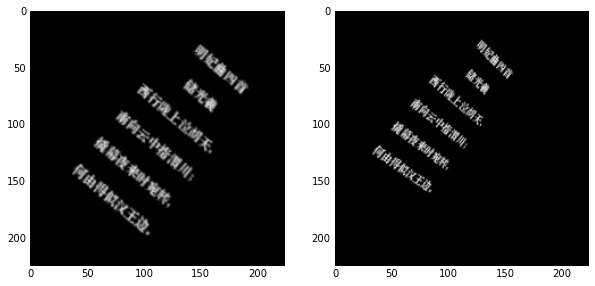

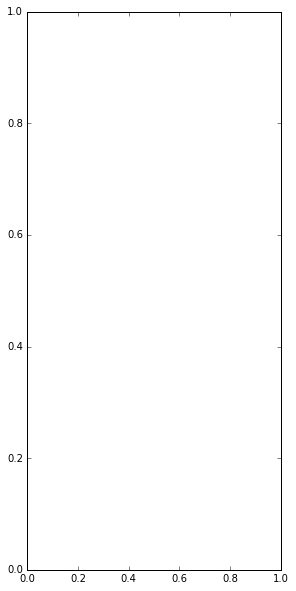

In [36]:
import train
reload(train)
from train import *
epochs = [83]
epoch = epochs[0]

(input_shp, opt, path, learning_rate, decay, epochs, batchsize, ksize,
  store, paraf, stride, acc, samples) = get_config('config/exp5.json')

print('load parameters from %s, epoch %d.' % (paraf, epoch))
iid = int(np.random.rand(1) * 400)
idx = int(np.random.rand(1) * 30)
ids = [[169, 6], [58, 3], [233, 6], [365, 25]]
idsr = np.vstack((np.random.rand(5) * 400, np.random.rand(5) * 30)).astype(np.int).T
# iid = 169
# idx = 6
# iid = 58
# idx = 3
# iid = 233
# idx = 6
iid = 365
idx = 25
with h5.File(path + 'meta.h5') as dat:
  Ps = dat['Ps'][:] * 1e4
# for epoch in epochs:
for iid, idx in idsr:
  print(iid, idx)
  paraf = str(epoch) + '.h5'
  load_parameter(network['pfc_out'], tmp_dir + paraf)
  mkdir(tmp_dir)
  img = np.rollaxis(cv2.imread(path + 'imgs/' + str(iid) + '/' + str(idx) + '.jpg'), 2, 0)
  img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
  rslt = predict['psp'](img)
  warp = np.eye(3);
  warp[2, 0 : 2] = -rslt / 1e4;
  imgwarp = predict['pspT'](img)[0]
  print(rslt)
  print(Ps[iid][idx, :])
  print(abs(rslt - Ps[iid][idx]) / Ps[iid][idx] * 100)
#   imgT = np.rollaxis(predict['pspT'](img)[0, :], 0, 3)
#   print(imgT.shape)
  figs, axs = plt.subplots(1, 2, figsize = (10, 10))
#   axs[0].imshow(cv2.warpPerspective(
#       cv2.imread(path + 'imgs/' + str(iid) + '/' + str(idx) + '.jpg'), warp, (224, 224)))
  axs[0].imshow(np.rollaxis(imgwarp, 0, 3).astype(np.uint8))
  axs[1].imshow(cv2.imread(path + 'imgs/' + str(iid) + '/' + str(idx) + '.jpg'))

[DimShuffle{0,3,1,2}.0, Subtensor{int64}.0, Elemwise{true_div,no_inplace}.0, Elemwise{true_div,no_inplace}.0]


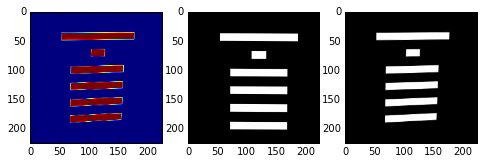

In [58]:
import model
reload(model)

input_var = T.tensor4('input', dtype='float32')
P_var = T.tensor3('Ps', dtype = 'float64')
network = {}
network['input'] = lasagne.layers.InputLayer((None, 3, 224, 224), input_var = input_var)
network['psinput'] = lasagne.layers.InputLayer((None, 3, 3), input_var = P_var)
network['psp'] = model.PerspectiveLayer(network['input'],
                                        network['psinput'], method = 'all')

warp = np.eye(3);
theta = 0.3 * np.pi
warp[2, 2] = 1
# warp[0 : 2, 2] = np.array([-0, -0])
# warp[2, 0 : 2] = np.array([3e-4, 2e-4])
warp = np.linalg.inv(warp).reshape(1, 3, 3);

print(lasagne.layers.get_output(network['psp']))
predimg = theano.function([input_var, P_var], lasagne.layers.get_output(network['psp']))

img = cv2.imread('/home/yancz/text_generator/data/angle/' + 'gt/0/' + str(0) + '.jpg')
imgD = np.rollaxis(img, 2, 0).reshape(1, 3, 224, 224)
# img = np.arange(25).reshape(1, 1, 5, 5).astype(np.float32)
ret, idx, x_s, y_s = predimg(imgD, warp)
# print(output)
# print(ret[0])
# print(img)
# print([ret[i].shape for i in range(len(ret))])
# imgT = predimg(imgD, warp)
# print(x.reshape(-1, 4), y)
figs, axes = plt.subplots(1,3, figsize=(8, 4))
axes[0].imshow(ret[0][0, :].astype(np.uint8))
axes[1].imshow(img)
axes[2].imshow(cv2.warpPerspective(img, np.linalg.inv(warp[0, :]), (224, 224)))

In [ ]:
A = T.zeros(100)
B = T.fvector('B')
# C = T.fvector('C')
# D = ((0.7 > B) & (B > 0.5) & (0.7 > C) & (C > 0.5)).nonzero()
C = T.set_subtensor(A[(B > 0.5).nonzero()], 1)
# C = (B > 0.5).nonzero()
# f = theano.function([B, C], D)
f = theano.function([B], C)
# b = np.random.rand(100).astype('float32')
# c = np.random.rand(100).astype('float32')
# print(np.where((b > 0.5) & (b < 0.7) & (c > 0.5) & (c < 0.7)))
print(f(b))